# Conv1D input layer


- Sliding Window Data 생성

- Conv1D + LSTM model 작성

- Learning Rate Tunning

- Window Size Tuning

### Sunspots 데이터셋을 활용하여 window_dataset 만들기

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
np.random.seed(42)
tf.random.set_seed(51)

url = 'https://storage.googleapis.com/download.tensorflow.org/data/Sunspots.csv'
df = pd.read_csv(url, skiprows=0, index_col=0)   #첫 줄은 header이므로 skip 
df.shape

(3235, 2)

Data 시각화

3235


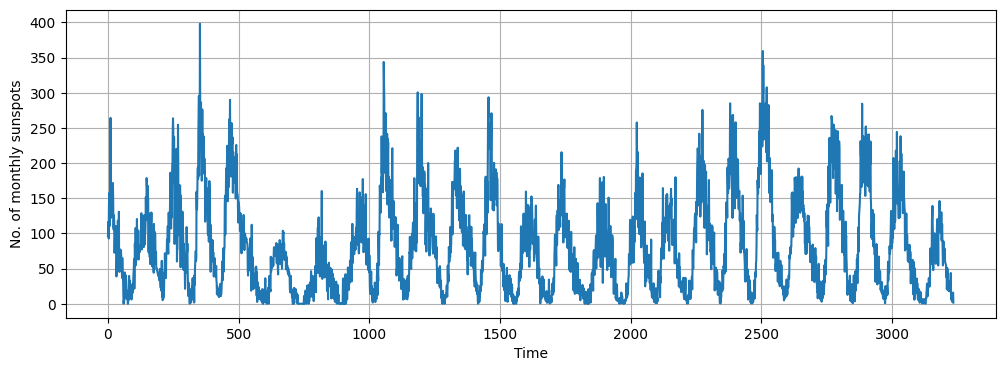

In [3]:
# df['Monthly Mean Total Sunspot Number'] 에서 월간 태양 흑점 수 데이터를 가져옴
series = df['Monthly Mean Total Sunspot Number'].values

# 시간 배열 생성, 시리즈의 크기만큼 시간 인덱스를 생성
time = range(series.size)
# 시리즈 배열의 크기를 출력
print(series.size)

plt.figure(figsize=(12, 4))

# 시간에 따른 태양 흑점 수를 선 그래프로 그림
plt.plot(time, series)

plt.xlabel("Time")
plt.ylabel("No. of monthly sunspots")
plt.grid(True)

- 시간 절약을 위해 최근 1000 개월치 data 만 이용

In [4]:
time = df.iloc[-1000:, 0].values
time_series = df.iloc[-1000:, 1].values
time.shape, time_series.shape

((1000,), (1000,))

### windowed dataset 생성

1. series를 이용해 tf.data.Dataset.from_tensor_slices로 데이터셋을 생성합니다.  
2. ds.window를 사용하여 입력 데이터셋을 지정한 윈도우 크기와 함께 슬라이딩 윈도우 방식으로 나눕니다.   drop_remainder=True는 윈도우 크기보다 작은 마지막 윈도우를 제거합니다.  
3. ds.flat_map을 사용하여 각 윈도우를 하나의 배치로 펼칩니다.  
4. ds.shuffle을 사용하여 데이터셋을 무작위로 섞습니다. 이렇게 하면 모델이 훈련 데이터의 순서를 기억하는 것을 방지할 수 있습니다.  
5. ds.map에서 입력 데이터의 마지막 원소를 제외한 부분을 X로 사용하고, 첫 원소를 제외한 부분을 y로 사용하여 다중 스텝 출력을 준비합니다.  
6. 마지막으로, ds.batch를 사용하여 지정된 배치 크기로 데이터를 나누고, ds.prefetch를 사용하여 효율적인 학습을 위해 데이터를 미리 가져옵니다.

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer).map(lambda w: (w[:-1], w[1:]))  # multi-step output
    ds = ds.batch(batch_size).prefetch(1)
    return ds

#### 예측을 위한 보조 함수

- 훈련이 끝난 후에는 시계열 데이터를 모델이 처리할 수 있는 형태로 변환해서 예측을 진행해야 합니다. 이 때 데이터 배치 생성이나 셔플링은 필요하지 않습니다.
- 우리는 예측을 위해 지도학습에서 사용하는 레이블이 필요하지 않으므로, 데이터 윈도우 크기를 조정할 때 1을 더할 필요가 없습니다.

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(1).prefetch(1)
    forecast = model.predict(ds)
    return forecast

### train/validation set 분리

In [7]:
split_time = 700

time_train = time[:split_time]
time_test = time[split_time:]

X_train = time_series[:split_time]
X_test  = time_series[split_time:]

len(time_train), len(time_test), len(X_train), len(X_test)

(700, 300, 700, 300)

In [8]:
window_size = 132  #132, 64, 30
batch_size = 64
shuffle_buffer_size = 1000

train_ds = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_size)
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>

## Conv1D + LSTM + Bidirectional

- Causal Convolution(인과관계 컨벌루션)은 시간 t의 출력이 시간 t - 1의 입력에서만 파생되도록 합니다.

- Causal padding 은 `Conv1D`에만 지원됩니다.

<img src="https://user-images.githubusercontent.com/24662250/29258799-9b3ff514-80f7-11e7-83e4-ab701fdc2720.png" width=500 />

인과 관계 컨벌루션은 시간 순서를 중요시하는 시계열 데이터를 다룰 때 쓰는 특별한 컨벌루션 방법입니다. 이 방법을 쓰면, 특정 시간의 결과를 계산할 때 그 시간 이후의 데이터는 사용되지 않고, 오직 그 시간과 그 이전의 데이터만 사용됩니다. 이는 결과가 과거와 현재의 정보에만 기반하도록 하여, 데이터 사이의 자연스러운 인과 관계를 보존합니다.

패딩은 컨벌루션을 수행하기 전에 데이터 주변에 특정 값을 추가하는 과정을 말합니다. 인과 관계 컨벌루션에서 사용되는 'causal padding'은 데이터의 앞부분(과거)에만 패딩을 추가하는 방법입니다. 이렇게 함으로써, 컨벌루션 필터가 데이터의 뒷부분(미래)을 '보지 못하게' 하여, 미래 데이터를 참조하지 않도록 합니다. 쉽게 말해, 예측을 할 때 현재 시점에서 아직 일어나지 않은 일을 참고하지 않도록 하는 것입니다.

TensorFlow에서는 이런 인과 관계 컨벌루션을 구현할 때 `Conv1D` 레이어와 `padding='causal'` 옵션을 사용합니다. 이 옵션을 설정하면, 모델이 과거 데이터만을 참고하여 현재와 미래를 예측하도록 만들어

예를 들어, 시간 스텝에 따른 데이터 'abcde'에 인과 관계 패딩을 적용하면, 'aaabcde'와 같이 됩니다. 여기서 'a'는 과거 데이터를 의미하며, 필터는 'd'와 'e'를 현재 및 미래의 스텝으로 볼 때 이들을 참조하지 않습니다.줍니다.

In [9]:
def model_define(kernel_size, lambda_scale):
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=32, kernel_size=kernel_size, strides=1, padding="causal", 
                             activation="relu", input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * lambda_scale)
    ])
    return model

- 초기 epoch 100 동안 learning rate를 변경해 가며 loss가  증가하지 않는 가장 큰 learning rate 를 찾아냅니다.

In [10]:
model = model_define(kernel_size=5, lambda_scale=250)

# 학습률 스케줄러 정의: epoch에 따라 1e-8에서 시작하여 10의 (epoch/20)제곱 배만큼 증가하는 학습률을 적용
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
                lambda epoch: 1e-8 * 10**(epoch / 20)
)

# SGD(확률적 경사 하강법) 옵티마이저 정의: 초기 학습률 1e-8, 모멘텀 0.9로 설정
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

# 모델 컴파일: Huber 손실 함수와 위에서 정의한 옵티마이저 사용, 평가 지표로 'mae'(평균 절대 오차) 사용
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# 모델 훈련: 훈련 데이터셋을 사용하여 100 에포크 동안 훈련, 학습률 스케줄러 콜백을 사용
history = model.fit(train_ds, epochs=100, verbose=1, callbacks=[lr_schedule])

Epoch 1/100
9/9 [==============================] - 4s 75ms/step - loss: 83.8253 - mae: 84.3239 - lr: 1.0000e-08
Epoch 2/100
9/9 [==============================] - 1s 66ms/step - loss: 83.0478 - mae: 83.5464 - lr: 1.1220e-08
Epoch 3/100
9/9 [==============================] - 1s 64ms/step - loss: 81.8760 - mae: 82.3743 - lr: 1.2589e-08
Epoch 4/100
9/9 [==============================] - 1s 64ms/step - loss: 80.5188 - mae: 81.0168 - lr: 1.4125e-08
Epoch 5/100
9/9 [==============================] - 1s 62ms/step - loss: 79.0567 - mae: 79.5550 - lr: 1.5849e-08
Epoch 6/100
9/9 [==============================] - 1s 63ms/step - loss: 77.5148 - mae: 78.0130 - lr: 1.7783e-08
Epoch 7/100
9/9 [==============================] - 1s 61ms/step - loss: 75.9477 - mae: 76.4456 - lr: 1.9953e-08
Epoch 8/100
9/9 [==============================] - 1s 62ms/step - loss: 74.3611 - mae: 74.8589 - lr: 2.2387e-08
Epoch 9/100
9/9 [==============================] - 1s 61ms/step - loss: 72.8176 - mae: 73.3155 - lr: 2.5

- 안정적 상태에서 최소 mae 를 얻은 learning rate 선택

Text(0, 0.5, 'Huber Loss')

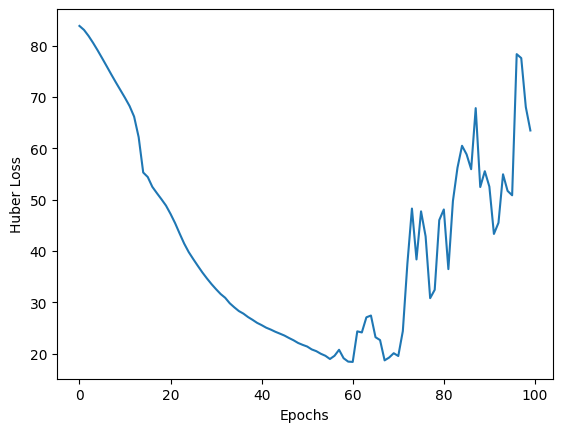

In [11]:
plt.plot(history.history["loss"])
plt.xlabel('Epochs')
plt.ylabel('Huber Loss')

(1e-07, 0.0001, 12.0, 30.0)

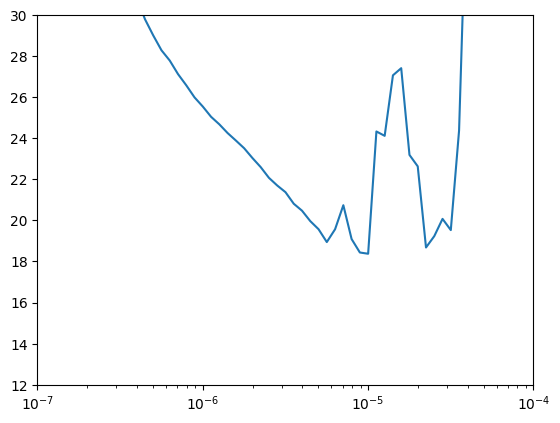

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 12, 30])

이 코드에서 idx는 주어진 history.history["loss"] 리스트에서 최소 손실 값의 위치를 찾아 리스트 형태로 반환합니다. 리스트에는 최소 손실 값에 해당하는 위치가 True로 표시되고 나머지 위치는 False로 표시됩니다.

In [13]:
idx = list(np.array(history.history["loss"]) == np.min(history.history["loss"]))

In [14]:
best_lr = np.array(tuple(history.history['lr']))[idx]
best_lr

array([1.e-05], dtype=float32)

### Hyper Parameter Tuning

- optimal learning rate로 충분한 epoch train   
    - optimal lr <-- best_lr  
    - epochs <-- 500

- kernel size를 3으로 조정

- Lambda layer 를 `x * 200`으로 조정

In [15]:
# 현재 세션의 모든 변수와 모델을 초기화합니다. 
tf.keras.backend.clear_session()

EPOCHS = 300

# 훈련 데이터셋을 생성
train_set = windowed_dataset(X_train, window_size, 
                             batch_size, shuffle_buffer_size)

# 모델 정의
model = model_define(kernel_size=3, lambda_scale=200)

# 이전에 찾은 최적의 학습률(best_lr[0])을 사용합니다. 모멘텀은 0.9로 설정합니다.
optimizer = tf.keras.optimizers.SGD(learning_rate=best_lr[0], momentum=0.9)

# 손실 함수로는 Huber 손실을 사용하고,평가 지표로는 평균 절대 오차(mae)를 사용
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=EPOCHS, verbose=1)

Epoch 1/300
9/9 [==============================] - 4s 68ms/step - loss: 92.2466 - mae: 92.7453
Epoch 2/300
9/9 [==============================] - 1s 58ms/step - loss: 60.5840 - mae: 61.0816
Epoch 3/300
9/9 [==============================] - 1s 61ms/step - loss: 43.1515 - mae: 43.6490
Epoch 4/300
9/9 [==============================] - 1s 58ms/step - loss: 34.3251 - mae: 34.8212
Epoch 5/300
9/9 [==============================] - 1s 61ms/step - loss: 29.5242 - mae: 30.0195
Epoch 6/300
9/9 [==============================] - 1s 59ms/step - loss: 27.0321 - mae: 27.5268
Epoch 7/300
9/9 [==============================] - 1s 61ms/step - loss: 25.2855 - mae: 25.7797
Epoch 8/300
9/9 [==============================] - 1s 58ms/step - loss: 24.0048 - mae: 24.4994
Epoch 9/300
9/9 [==============================] - 1s 60ms/step - loss: 24.5206 - mae: 25.0154
Epoch 10/300
9/9 [==============================] - 1s 59ms/step - loss: 23.3354 - mae: 23.8295
Epoch 11/300
9/9 [==============================]

9/9 [==============================] - 1s 77ms/step - loss: 8.6684 - mae: 9.1527
Epoch 172/300
9/9 [==============================] - 1s 77ms/step - loss: 8.7930 - mae: 9.2774
Epoch 173/300
9/9 [==============================] - 1s 77ms/step - loss: 8.2574 - mae: 8.7399
Epoch 174/300
9/9 [==============================] - 1s 79ms/step - loss: 8.9176 - mae: 9.4023
Epoch 175/300
9/9 [==============================] - 1s 77ms/step - loss: 8.8028 - mae: 9.2876
Epoch 176/300
9/9 [==============================] - 1s 77ms/step - loss: 8.4755 - mae: 8.9596
Epoch 177/300
9/9 [==============================] - 1s 78ms/step - loss: 8.2023 - mae: 8.6852
Epoch 178/300
9/9 [==============================] - 1s 76ms/step - loss: 7.9699 - mae: 8.4523
Epoch 179/300
9/9 [==============================] - 1s 77ms/step - loss: 7.9868 - mae: 8.4686
Epoch 180/300
9/9 [==============================] - 1s 78ms/step - loss: 8.1634 - mae: 8.6459
Epoch 181/300
9/9 [==============================] - 1s 77ms/ste

9/9 [==============================] - 1s 77ms/step - loss: 5.6664 - mae: 6.1425
Epoch 258/300
9/9 [==============================] - 1s 78ms/step - loss: 5.7103 - mae: 6.1870
Epoch 259/300
9/9 [==============================] - 1s 77ms/step - loss: 5.8495 - mae: 6.3259
Epoch 260/300
9/9 [==============================] - 1s 77ms/step - loss: 5.9823 - mae: 6.4616
Epoch 261/300
9/9 [==============================] - 1s 77ms/step - loss: 5.2511 - mae: 5.7249
Epoch 262/300
9/9 [==============================] - 1s 79ms/step - loss: 6.2708 - mae: 6.7507
Epoch 263/300
9/9 [==============================] - 1s 77ms/step - loss: 5.6600 - mae: 6.1359
Epoch 264/300
9/9 [==============================] - 1s 78ms/step - loss: 5.5924 - mae: 6.0674
Epoch 265/300
9/9 [==============================] - 1s 77ms/step - loss: 6.1207 - mae: 6.5996
Epoch 266/300
9/9 [==============================] - 1s 79ms/step - loss: 5.9491 - mae: 6.4269
Epoch 267/300
9/9 [==============================] - 1s 78ms/ste

훈련 과정에서 계산된 평균 절대 오차(MAE)와 손실 값(Loss)을 시각화 합니다.

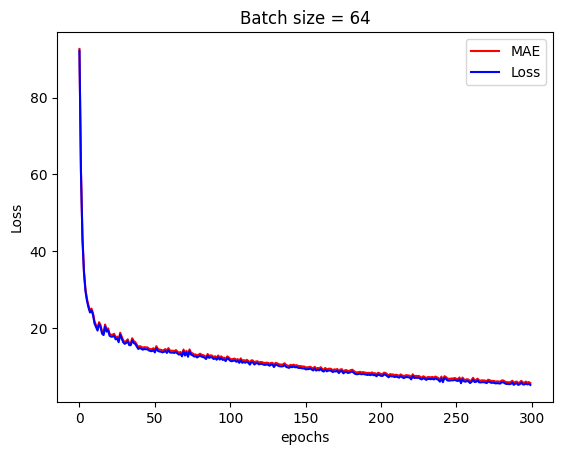

In [16]:
mae=history.history['mae']
loss=history.history['loss']

plt.plot(mae, 'r', label='MAE')
plt.plot(loss, 'b', label='Loss')
plt.title('Batch size = {}'.format(batch_size))
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

In [17]:
print(time_series.shape)
print(X_test.shape)

(1000,)
(300,)


X_test data 를 이용하여 forecast

In [18]:
# model_forecast 함수를 사용하여 X_test 데이터에 대한 예측을 수행
forecast = model_forecast(model, X_test, window_size)
forecast.shape

169/169 [==============================] - 2s 8ms/step


(169, 132, 1)

In [19]:
# 예측 결과의 마지막 시간 단계에서 예측 값을 선택하고, 배치 차원을 제거
forecast = forecast[:, -1, 0]
forecast.shape

(169,)

### True value와 prediction value 비교 시각화

X_test(실제 값)와 forecast(예측 값)을 시계열 데이터로 시각화하는 코드입니다.

plt.plot() 함수를 사용하여 time_test와 X_test(실제 값)를 그래프로 그리고, 범례 레이블을 'True'로 설정합니다.  
plt.plot() 함수를 사용하여 time_test의 끝부분에서 예측된 값의 길이만큼과 forecast(예측 값)를 그래프로 그리고, 범례 레이블을 'Forecast'로 설정합니다.  

초반 window_size 만큼의 데이터는 예측 과정에서 skip되므로, 그래프에서도 그 부분이 생략되어 그려집니다.

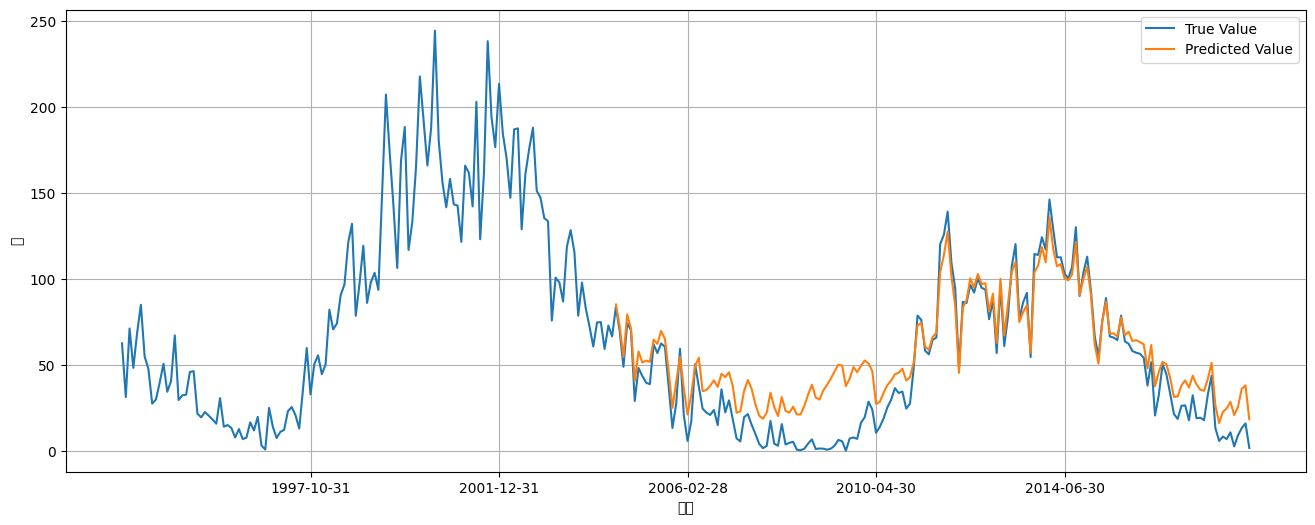

In [21]:
plt.figure(figsize=(16, 6))

# 실제 테스트 데이터를 그래프에 플롯
plt.plot(time_test, X_test, label='True Value')

# 예측 데이터를 그래프에 플롯, 예측 배열의 길이에 맞춰 time_test의 마지막 부분을 사용
plt.plot(time_test[-len(forecast):] , forecast, label='Predicted Value')

plt.xlabel("시간")
plt.ylabel("값")

# x축의 눈금 설정
plt.xticks([50, 100, 150, 200, 250])
plt.grid(True)
plt.legend()

X_test와 forecast 간의 평균 제곱 오차(mean squared error, MSE)와 평균 절대 오차(mean absolute error, MAE)를 계산하고 출력합니다.

In [22]:
print(tf.keras.metrics.mean_squared_error(X_test[window_size-1:], forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(X_test[window_size-1:], forecast).numpy())

260.05215
12.697777


## Window Size를 바꾸어 가며 Tuning

11 년 주기의 noise 가 심한 data 이므로 다양한 size 의 window 를 try 하며 model tuning --> 132, 30, 64 등